### Introduction:

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt


I will start by reading each csv file one by one then preprossesing each df to merge them into one.

In [137]:
try:
    df_con = pd.read_csv('datasets/final_project/contract.csv') #read csv file stored locally on my laptop
except:
    df_con = pd.read_csv('/datasets/final_provider/contract.csv') #make an exception for when I upload the project to Practicum

In [138]:
df_con.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [139]:
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


There are no null values but I do see that the last column of TotalCharges should be of type float since it is an amount of money. Begin and End Dates should not be of type object but I am going to perform some data engineering on them and will convert to date to extract target and to extract the Begin Year.

In [140]:
df_con.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


We know we can deduce or binary target from EndDate so lets see if it is balance or unbalanced. 

In [141]:
df_con[df_con['EndDate']=='No'].count()[1]

5174

In [142]:
df_con[df_con['EndDate']!='No'].count()[1]

1869

In [143]:
df_con[df_con['EndDate']!='No'].count()[1]/len(df_con['EndDate'])

0.2653698707936959

The Churn rate is about 26.5% which is quite high for a telecom. This also means the target binary class is unbalanced since the majority of customers do not churn.

In [144]:
df_con.query("TotalCharges == ' '" ) #Looking for empty strings and to replace with zeros.

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


2020-02-01 seems like it is around the date that the data was pulled lets look at the EndDate column as well to confirm.

In [145]:
End_Dates = df_con.EndDate[df_con['EndDate']!='No']

In [146]:
End_Dates.head(50)

2      2019-12-01 00:00:00
4      2019-11-01 00:00:00
5      2019-11-01 00:00:00
8      2019-11-01 00:00:00
13     2019-10-01 00:00:00
18     2019-11-01 00:00:00
20     2019-12-01 00:00:00
22     2019-12-01 00:00:00
26     2019-11-01 00:00:00
27     2019-12-01 00:00:00
29     2019-11-01 00:00:00
36     2019-11-01 00:00:00
38     2019-12-01 00:00:00
39     2019-11-01 00:00:00
47     2020-01-01 00:00:00
51     2019-12-01 00:00:00
53     2019-11-01 00:00:00
55     2020-01-01 00:00:00
64     2020-01-01 00:00:00
80     2019-12-01 00:00:00
82     2019-10-01 00:00:00
95     2019-12-01 00:00:00
97     2019-11-01 00:00:00
99     2020-01-01 00:00:00
104    2019-11-01 00:00:00
110    2019-12-01 00:00:00
113    2019-11-01 00:00:00
117    2019-12-01 00:00:00
122    2019-12-01 00:00:00
126    2020-01-01 00:00:00
131    2020-01-01 00:00:00
133    2020-01-01 00:00:00
134    2020-01-01 00:00:00
139    2019-11-01 00:00:00
141    2019-10-01 00:00:00
147    2020-01-01 00:00:00
151    2020-01-01 00:00:00
1

Seems like all end dates are on the first of each month.

In [147]:
End_Dates2 = pd.to_datetime(End_Dates, format='%Y-%m-%d', errors='coerce')

In [148]:
End_Dates2.max() #Getting the maximum end date as a marker to determine tenure for customers

Timestamp('2020-01-01 00:00:00')

In [149]:
Begin_Dates2 = pd.to_datetime(df_con['BeginDate'] , format='%Y-%m-%d', errors='coerce')

In [150]:
Begin_Dates2.max() #Begin date is higher so I will assume this is the date the data was pulled

Timestamp('2020-02-01 00:00:00')

In [151]:
df_con['TotalCharges']  = df_con['TotalCharges'] .replace(' ', 0) #Replace empty with zero they all have a recent begin date

In [152]:
df_con['TotalCharges'] = df_con['TotalCharges'].astype(float) #Change to float.

In [153]:
df_con.info() #We can see that TotalCharges is now type float.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


This contract df is very important since it contains our target. If End_Date has an actual date in it then the customer churned. 

In [154]:
df_con.duplicated().sum() # No duplicates lets look at the next table.

0

In [155]:
df_con.customerID.nunique()

7043

In [156]:
try:
    df_int = pd.read_csv('datasets/final_project/internet.csv') #read csv file stored locally on my laptop
except:
    df_int = pd.read_csv('/datasets/final_provider/internet.csv')

In [157]:
df_int.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [158]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


No null values and all data types look correct. 

In [159]:
df_int.duplicated().sum() #No duplicates

0

In [160]:
df_int.customerID.nunique() #counting unique customers

5517

We can see that not all customers have internet as well which makes sense. The total customers from the contract table is 7043.

In [161]:
try:
    df_per = pd.read_csv('datasets/final_project/personal.csv') #read csv file stored locally on my laptop
except:
    df_per = pd.read_csv('/datasets/final_provider/personal.csv')

In [162]:
df_per.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [163]:
df_per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [164]:
df_per.customerID.nunique() #count unique ids and it matches the contract csv file

7043

In [165]:
df_per.duplicated().sum()

0

In [166]:
try:
    df_phn = pd.read_csv('datasets/final_project/phone.csv') #read csv file stored locally on my laptop
except:
    df_phn = pd.read_csv('/datasets/phone.csv')

In [167]:
df_phn.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [168]:
df_phn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [169]:
df_phn.customerID.nunique() 

6361

Merge the data-frames into one df with all the features.

In [170]:
df_mrg = pd.merge(df_con, df_int, on='customerID', how ='left')

In [171]:
df_mrg.head(20) #Looking for rows where InternetService is NaN

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No


In [172]:
df_mrg.fillna('No', inplace=True) #Fill NA with No since it means they don't have internet services.

In [173]:
df_mrg.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No


In [174]:
df_mrg.isna().sum() #Checking for NaNs

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [175]:
df_mrg2 = pd.merge(df_mrg, df_per , on='customerID', how ='left')

In [176]:
df_mrg2.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64

In [177]:
df_mrg2.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No


In [178]:
df_mrg3 = pd.merge(df_mrg2, df_phn , on='customerID', how ='left')

In [179]:
df_mrg3.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [180]:
df_mrg3.isna().sum()

customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
MultipleLines       682
dtype: int64

In [181]:
df_mrg3.fillna('None', inplace=True) #Have to fill with something other than No since No means 1 landline

In [182]:
df_mrg3.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [183]:
df_mrg3 = df_mrg3.rename(columns={'gender': 'Gender'}) #Keeping everything consistent

We now have all the dataframes merged into one big one for analysis and to run the ML models.

In [184]:
df_mrg3['Churned'] = df_mrg3['EndDate']!='No' #Create a target column with the target in binary format

In [185]:
df_mrg3['BeginDate'].max()

'2020-02-01'

In [186]:
df_mrg3.loc[df_mrg3['EndDate'] == 'No',  'EndDate'] = pd.to_datetime('2020-02-01 00:00:00') #max begin date
df_mrg3['Tenure'] =  (pd.to_datetime(df_mrg3['EndDate']) - pd.to_datetime(df_mrg3['BeginDate'])).dt.days

I'm using feature engineering to create a feature that contains the tenure or longevity of a customer in days. I am assuming the data was pulled somewhere close to 2020-02-01 which is the max BeginDate. On the data description given we also can see: "The contract information is valid as of February 1, 2020." 

In [187]:
df_mrg3.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned,Tenure
0,7590-VHVEG,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,None,False,31
1,5575-GNVDE,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,No,False,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,True,61
3,7795-CFOCW,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,None,False,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,True,61


In [188]:
df_mrg3.drop('EndDate', axis=1, inplace=True)

*** Churned is new target so I can drop EndDate. ***

In [189]:
df_mrg3.head()

,customerID,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned,Tenure
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,...,No,No,No,Female,0,Yes,No,None,False,31
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,...,No,No,No,Male,0,No,No,No,False,1036
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,...,No,No,No,Male,0,No,No,No,True,61
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,...,Yes,No,No,Male,0,No,No,None,False,1371
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,...,No,No,No,Female,0,No,No,No,True,61


In [190]:
df_mrg3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null   object 


In [191]:
df_mrg3['YearBegin'] = pd.to_datetime(df_mrg3['BeginDate']).dt.year #Extracting Year for model

In [192]:
df_mrg3['YearBegin'].unique() #From 2013 to 2020

array([2020, 2017, 2019, 2016, 2018, 2014, 2015, 2013])

In [193]:
df_mrg3['YearBegin'].dtype

dtype('int64')

In [194]:
df_mrg3.drop('BeginDate', axis=1, inplace=True)

In [195]:
df_mrg3.drop('customerID', axis=1, inplace=True)

In [196]:
df_mrg3.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned,Tenure,YearBegin
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,False,31,2020
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,False,1036,2017
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,True,61,2019
3,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,False,1371,2016
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,True,61,2019


In [197]:
len(df_mrg3['Churned'])

7043

In [198]:
len(df_mrg3[df_mrg3['Churned'] == False]) 

5174

In [199]:
len(df_mrg3[df_mrg3['Churned'] == True])/len(df_mrg3['Churned'])#Checking Churn rate again.

0.2653698707936959

In [200]:
df_mrg3.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,Tenure,YearBegin
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.162147,985.996166,2016.878603
std,30.090047,2266.794470,0.368612,747.587844,1.970573
min,18.250000,0.000000,0.000000,0.000000,2013.000000
25%,35.500000,398.550000,0.000000,273.000000,2015.000000
50%,70.350000,1394.550000,0.000000,883.000000,2017.000000
75%,89.850000,3786.600000,0.000000,1676.000000,2019.000000
max,118.750000,8684.800000,1.000000,2191.000000,2020.000000


MonthlyCharges and TotalCharges look like they have values that make sense and there are no maximum values that look completely out of reason and with more than like 5 standard deviations away from the mean.

In [201]:
df_mrg3['YearBegin'].unique()

array([2020, 2017, 2019, 2016, 2018, 2014, 2015, 2013])

In [202]:
df_mrg3.pivot_table(index='YearBegin', columns='Churned',values='TotalCharges', aggfunc='mean' )

Churned,False,True
YearBegin,,
2013,NaN,7138.381250
2014,5122.333668,6316.828061
2015,3786.340329,4646.533740
2016,2746.657120,3442.294483
2017,1914.200000,2376.138442
2018,1074.894196,1255.280952
2019,347.523053,252.649643
2020,36.200000,NaN


In [203]:
df_mrg3.pivot_table(index='YearBegin', columns='Churned',values='TotalCharges', aggfunc='median' )

Churned,False,True
YearBegin,,
2013,NaN,7611.050
2014,5714.200,6563.375
2015,4079.550,4941.800
2016,2878.475,3580.300
2017,1983.875,2440.150
2018,1074.650,1217.250
2019,251.625,146.900
2020,24.950,NaN


As we can see the total charges for customers that churned are consistently higher. So it could be that they are getting slapped with early cancelation fees if they left the telcom before their contract ended. It could also be that the have more services like internet or more add ons but this is supposed to work the opposite way. The more services a customer has with the same company the more "sticky" that customer should be meaning their chances of churning should be less than someone who only has basic services or few services with a company. Lets investigate further. 

I am dropping TotalCharges since it could cause Data Leakage. If a customer churns before their contract has come to full term there could be penalty charges included in the TotalCharges column but this is only after the fact we know the customer churned and this information should not be available in the test set.

In [204]:
df_mrg3.drop('TotalCharges', axis=1, inplace = True)

**Dropping TotalCharges caused my AUC_ROC to drop but I do believe it could cause data leakage.**

In [205]:
df_mrg3.pivot_table(index='YearBegin', columns='Churned',values='MonthlyCharges', aggfunc='mean' )

Churned,False,True
YearBegin,,
2013,NaN,100.531250
2014,74.558266,96.164796
2015,67.974760,88.471138
2016,62.697006,84.333448
2017,61.193266,83.348492
2018,54.638531,78.790635
2019,49.077869,65.633792
2020,38.067213,NaN


In [206]:
df_mrg3.pivot_table(index='YearBegin', columns='Churned',values='MonthlyCharges', aggfunc='mean' )

Churned,False,True
YearBegin,,
2013,NaN,100.531250
2014,74.558266,96.164796
2015,67.974760,88.471138
2016,62.697006,84.333448
2017,61.193266,83.348492
2018,54.638531,78.790635
2019,49.077869,65.633792
2020,38.067213,NaN


It is surprising for me to see that the monthly bill is also higher for customers that churned on average. We look at the year they begin to get a sense of longevity but customers with more services should be sticker. Next I will look at customers with Internet service and extra landline services and see what the churn rate is for customers with those services and not with any added services and multiple or one landlines. 

In [207]:
pivoted = df_mrg3.pivot_table(index='InternetService', columns='Churned',values='MonthlyCharges', aggfunc='count' )

In [208]:
pivoted

Churned,False,True
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
No,1413,113


In [209]:
pivoted.columns

Index([False, True], dtype='object', name='Churned')

In [210]:
result = pivoted.loc[:, True] / (pivoted.loc[:, True] + pivoted.loc[:, False])

In [211]:
print(result)

InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
dtype: float64


Something seems very strange here. Customers with Fiber Optic internet connection have a very high rate of churn! It could be that this service of fiber is the culprit of so many people leaving the company. Customers that don't have internet connection with Interconnect churn at the lowest rate of .074 and customers with Fiber churn at .41 that is 5.5 times higher rate of churn and majority of customers have either DSL or Fiber. Now lets look at landlines.

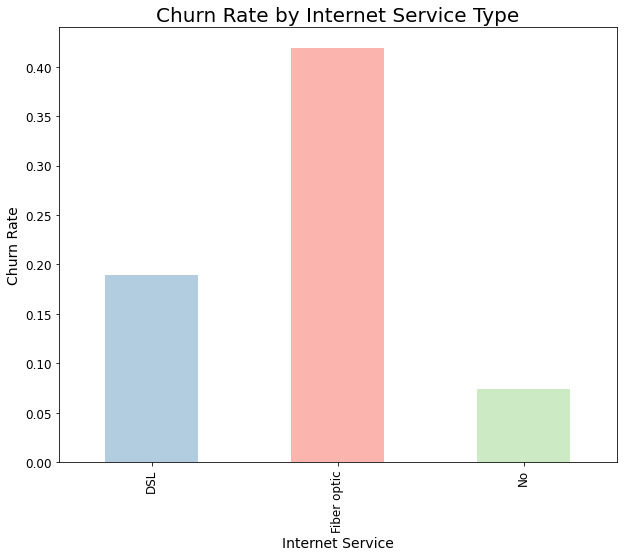

In [212]:
result.plot(kind='bar', color=['#b3cde0', '#fbb4ae', '#ccebc5'], width=0.5, figsize=(10,8))

plt.title('Churn Rate by Internet Service Type', fontsize=20)

# Set x and y axis labels and their font sizes
plt.xlabel('Internet Service', fontsize=14)
plt.ylabel('Churn Rate', fontsize=14)

# Set x and y axis label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Customers with no Internet service have the lowest churn rate.

In [213]:
pivoted1 = df_mrg3.pivot_table(index='MultipleLines', columns='Churned',values='MonthlyCharges', aggfunc='count' )

In [214]:
result1 = pivoted.loc[:, True] / (pivoted.loc[:, True] + pivoted.loc[:, False])

In [215]:
print(result1)

InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
dtype: float64


Customers with multiple lines churn at a higher rate than customers with only one line or with no lines. This is also counter intuitive since the more services a customer has with a company the stickier they should be. 

Lets create a new column that is 1 if customer has all the added services that comes with internet service and zero if they don't have all of them.

In [216]:
cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# create a new column 'NoServices' with value True if all the columns in cols have 'No' value, False otherwise
df_mrg3['NoServices'] = df_mrg3[cols].apply(lambda x: all(val == 'No' for val in x), axis=1)

In [217]:
df_mrg3.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churned,Tenure,YearBegin,NoServices
0,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,False,31,2020,False
1,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,False,1036,2017,False
2,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,True,61,2019,False
3,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,False,1371,2016,False
4,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,True,61,2019,True


In [218]:
churn_no_services = df_mrg3[df_mrg3['NoServices'] == True]['Churned'].mean()
churn_with_services = df_mrg3[df_mrg3['NoServices'] == False]['Churned'].mean()

In [219]:
print(f"Churn rate for customers with no extra services: {churn_no_services:.2f}")
print(f"Churn rate for customers with extra services: {churn_with_services:.2f}")

Churn rate for customers with no extra services: 0.21
Churn rate for customers with extra services: 0.29


In [220]:
churn_services = pd.Series([0.21,  0.29],
                   index=['No_Services', 'Extra_Services'])

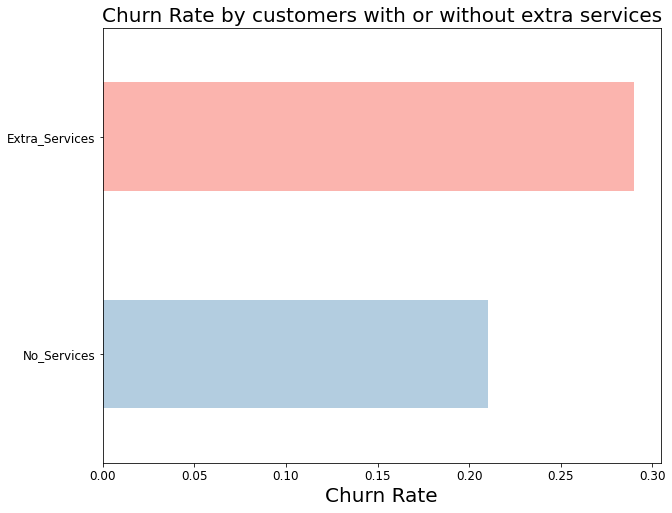

In [221]:
churn_services.plot(kind='barh', color=['#b3cde0', '#fbb4ae'], width=0.5, figsize=(10,8))

plt.title('Churn Rate by customers with or without extra services', fontsize=20)

plt.xlabel('Churn Rate', fontsize=20)

# Set x and y axis label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Again customers with more extra services churn at a higher rate than those with less add ons. This is a very bad sign for Interconnect since these customers should have a lower rate of churn since it takes a lot more effort for a customer to migrate all those services over to another company. They are also customers with highest ARPU or revenue per user since they are paying a higher monthly bill (see chart below). One thing we do know for sure is that Interconnect should not try to "save" customers with high probability of leaving with extra add ons. That is likely just going to make them even more likely to churn/leave. It seems that there are deeper issues with the services themselves since the more services the customer has with Interconnect the more frustrated they seem to get and the more likely to churn. This points to a lack of quality in the services provided compared to competitors. 

In [222]:
monthlybill_no_services = df_mrg3[df_mrg3['NoServices'] == True]['MonthlyCharges'].mean()
monthlybill_with_services = df_mrg3[df_mrg3['NoServices'] == False]['MonthlyCharges'].mean()

In [223]:
print(f"Monthly bill for customers with no extra services: {monthlybill_no_services:.2f}")
print(f"Monthly bill for customers with extra services: {monthlybill_with_services:.2f}")

Monthly bill for customers with no extra services: 32.79
Monthly bill for customers with extra services: 79.47


Things not looking great for Interconnect not only do they have a very high churn rate but they are losing their highest paying customers with the most amount of services the fastest (highest churn rate). 

In [224]:
ARPU_services = pd.Series([32.79, 79.47],
                   index=['No_Services', 'Extra_Services'])

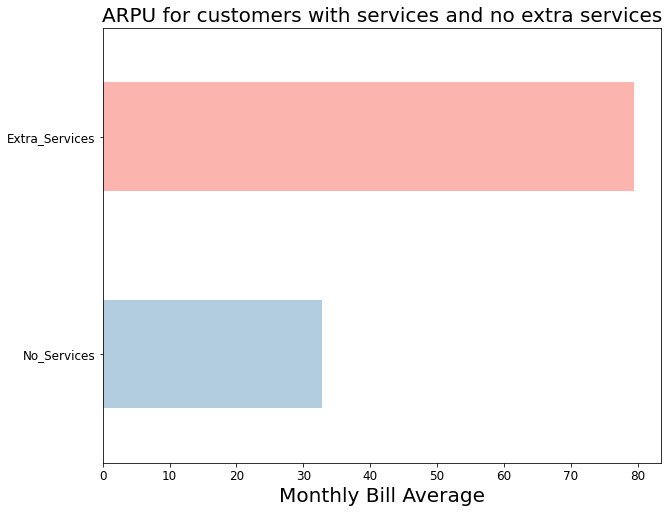

In [225]:
ARPU_services.plot(kind='barh', color=['#b3cde0', '#fbb4ae'], width=0.5, figsize=(10,8))

plt.title('ARPU for customers with services and no extra services', fontsize=20)

plt.xlabel('Monthly Bill Average', fontsize=20)


# Set x and y axis label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [226]:
pivoted3 = df_mrg3.pivot_table(index='Type', columns='Churned',values='MonthlyCharges', aggfunc='count' )

In [227]:
pivoted3

Churned,False,True
Type,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


In [228]:
result3 = pivoted3.loc[:, True] / (pivoted3.loc[:, True] + pivoted3.loc[:, False])

In [229]:
result3

Type
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
dtype: float64

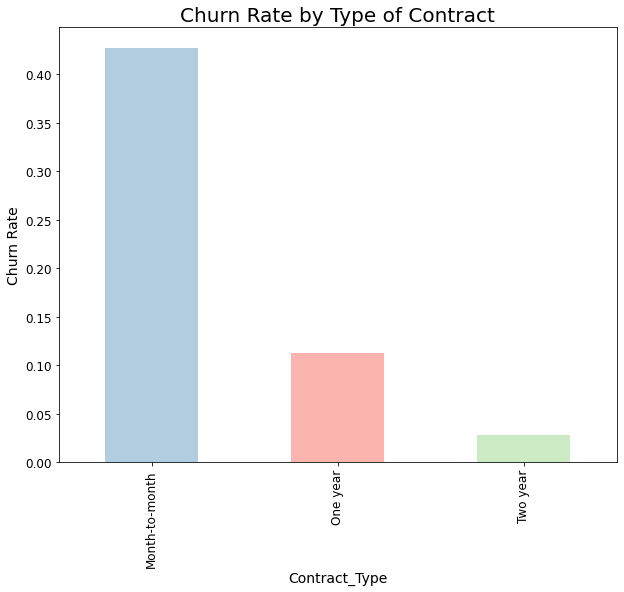

In [230]:
result3.plot(kind='bar', color=['#b3cde0', '#fbb4ae', '#ccebc5'], width=0.5, figsize=(10,8))

plt.title('Churn Rate by Type of Contract', fontsize=20)

plt.xlabel('Contract_Type', fontsize=14)
plt.ylabel('Churn Rate', fontsize=14)

# Set x and y axis label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [231]:
percentage_customers = (pivoted3.loc[:, True] + pivoted3.loc[:, False])/len(df_mrg3) #Percentage

In [232]:
percentage_customers

Type
Month-to-month    0.550192
One year          0.209144
Two year          0.240664
dtype: float64

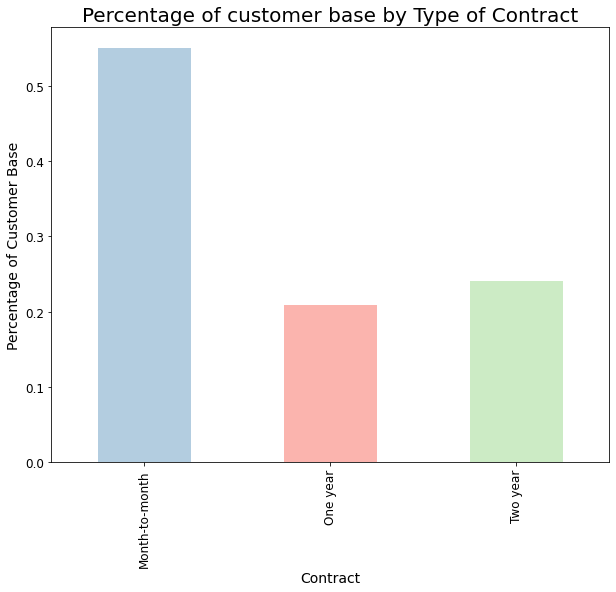

In [233]:
percentage_customers.plot(kind='bar', color=['#b3cde0', '#fbb4ae', '#ccebc5'], width=0.5, figsize=(10,8))

plt.title('Percentage of customer base by Type of Contract', fontsize=20)

plt.xlabel('Contract', fontsize=14)
plt.ylabel('Percentage of Customer Base', fontsize=14)

# Set x and y axis label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The majority of the customer base is on a month-to-month contract or in other words no contract whatsoever. This is also a huge culprit of why the churn is so high. This segment of customers (month-to-month) has the highest churn rate at a super high 43% churn rate! It makes sense because they will suffer not penalty if they leave the company.  Interconnect has to find a way to incentivize their existing customers to sign at least a 1 year contract but preferably a 2 year contract. That would be the best way to reduce churn. They could offer some savings on the bill or add perks like free "Online_Streaming" to cause customers to want to sign a contract. Also all new customers should be pushed heavily to sign a contract. There is no point in getting adds (additional customers) on the the month-to-month contract basis when almost half of them will churn. It is a waste of money and resources for Interconnect. 

In [234]:
#PaymentMethod
pivoted4 = df_mrg3.pivot_table(index='PaymentMethod', columns='Churned',values='MonthlyCharges', aggfunc='count' )


In [235]:
result4 = pivoted4.loc[:, True] / (pivoted4.loc[:, True] + pivoted4.loc[:, False])

In [236]:
result4

PaymentMethod
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
dtype: float64

In [237]:
percentage_payment = (pivoted4.loc[:, True] + pivoted4.loc[:, False])/len(df_mrg3)

In [238]:
percentage_payment

PaymentMethod
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Electronic check             0.335794
Mailed check                 0.228880
dtype: float64

I won't do an extra graph for the findings on the payment method but it is important to get customers on automatic payments which are Bank transfer or Credit Card. Customers on E-check have the highest rate of churn and they are not automatic. Mailed in check also has lower churn but not as low as the automatic payment methods and it is slower cash-flow and overhead to receive them in the mail which also has added cost for processing a mailed check. 

## Initial Conclusions after EDA:

The target data is binary and it is unbalanced the majority of the customers did not churn but still churn is quite high for a telecom and many customers are leaving. The company must act fast or they will be swallowed up by competition since these costumers are going to it's competitors. 

We can see that customers having fiber internet are at the highest risk of churning. Also customers that have internet and then have any of the addition services like for example:  StreamingMovies or OnlineBackup also churn at a higher rate which is the opposite of what should be happening since these customers should be stickier. This could point to a lack of quality in the services provided compared to competitors.

The main reason why customers with more services are not "stickier" is probably because of the high percentage of month-to-month contact customers. The vast majority of customers need to be on a contract of 1 or 2 years if the company really wants to reduce churn. 

The company also has to try to get customers on automatic payment methods since these tend to have a much better churn rate. But I think the main priority and focus needs to be on getting existing and new customers on contracts at all costs. 

### CatBoost Model

Distinguish which features are categorical.

In [239]:
df_mrg3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Gender            7043 non-null   object 
 12  SeniorCitizen     7043 non-null   int64  
 13  Partner           7043 non-null   object 
 14  Dependents        7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  Churned           7043 non-null   bool   


In [240]:
df_mrg3.drop('YearBegin', axis=1, inplace=True) #Drop YearBegin since it could cause data leakage.

In [241]:
cat_cols = list(df_mrg3.select_dtypes(include=['object']).columns)

In [242]:
print(cat_cols)

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Gender', 'Partner', 'Dependents', 'MultipleLines']


Split the data into train, test and validation.

In [243]:
df_mrg3['NoServices'] = df_mrg3['NoServices'].astype('int')

In [244]:
X = df_mrg3.drop('Churned', axis=1)

In [245]:
X.shape

(7043, 18)

In [246]:
X.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Tenure,NoServices
0,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,31,0
1,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,61,0
3,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,1371,0
4,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,61,1


In [112]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Gender            7043 non-null   object 
 12  SeniorCitizen     7043 non-null   int64  
 13  Partner           7043 non-null   object 
 14  Dependents        7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  Tenure            7043 non-null   int64  


In [113]:
y = df_mrg3['Churned']

In [114]:
le = LabelEncoder()
y = le.fit_transform(y) #Convert the target from true or false to zero or 1.

In [115]:
y

array([0, 0, 1, ..., 0, 1, 0])

*Note: I split the final merged dataframe in the fashion below to try to keep the True False proportions of 73% False and 27% True (customer churned). I will try to use the stratify parameter if need be.  

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)



In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=77, stratify=y_train)
    
    
    

In [118]:
(y_train==0).sum()

3311

In [119]:
(y_train==1).sum()

1196

In [120]:
(y_train==1).sum()/len(y_train)# The train set maintains the -
                             #correct churn proporting to match total churn rate

0.2653649877967606

Lets try to oversample the True or One in Churned target since they are only 26.5% of the target.

In [121]:
# apply oversampling to the training set
oversampler = RandomOverSampler(random_state=77)

In [122]:
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [123]:
(y_train_resampled==0).sum()

3311

In [124]:
(y_train_resampled==1).sum() #After oversampling we have the same proportion of 1 and 0.

3311

*** CatBoost approach***

My approach with CatBoost was to use a very small learning rate and use a very large number of iterations. This was viable since the data set was quite small with only about 7K rows. This would not be possible to use with a very large data frame because of the amount of time it would take to do this many iterations. CatBoost does cross validation under the hood.

In [125]:
model_cat = CatBoostClassifier(
                        iterations=190000, #I put this high since the df is small
                        learning_rate=0.0001,  #I tried many different learning rates but smaller is good when dataset is small
                        loss_function='Logloss',
                        eval_metric='AUC',
                        random_seed=77)

In [126]:
# train the model on the resampled training set
model_cat.fit(
    X_train_resampled, y_train_resampled, #using upsampling
    eval_set=(X_val, y_val), #use validation sets
    early_stopping_rounds=5000,
    verbose=10000,
    cat_features=cat_cols);

0:	test: 0.8242067	best: 0.8242067 (0)	total: 68.9ms	remaining: 3h 38m 19s
10000:	test: 0.8565629	best: 0.8565791 (9985)	total: 37s	remaining: 11m 6s
20000:	test: 0.8637932	best: 0.8638012 (19996)	total: 1m 16s	remaining: 10m 54s
30000:	test: 0.8682727	best: 0.8682767 (29979)	total: 1m 58s	remaining: 10m 32s
40000:	test: 0.8711163	best: 0.8711163 (39997)	total: 2m 40s	remaining: 10m
50000:	test: 0.8729986	best: 0.8730107 (49829)	total: 3m 20s	remaining: 9m 21s
60000:	test: 0.8739195	best: 0.8739276 (59995)	total: 4m 10s	remaining: 9m 1s
70000:	test: 0.8749495	best: 0.8749697 (69953)	total: 4m 54s	remaining: 8m 24s
80000:	test: 0.8760926	best: 0.8761047 (79900)	total: 5m 37s	remaining: 7m 44s
90000:	test: 0.8774659	best: 0.8774659 (89998)	total: 6m 24s	remaining: 7m 6s
100000:	test: 0.8795219	best: 0.8795260 (99995)	total: 7m 10s	remaining: 6m 27s
110000:	test: 0.8813638	best: 0.8813719 (109950)	total: 8m	remaining: 5m 49s
120000:	test: 0.8830845	best: 0.8830845 (119993)	total: 8m 48s	r

We can see CatBoost did very well and is already over .88 AUC-ROC for the metric on the validation and test sets. The CatBoost model does cross validation under the hood so we don't have to do that as a separate step. 

In [127]:
# predict the probabilities for the testing set
y_pred_proba = model_cat.predict_proba(X_test)[:, 1]


The AUC_ROC score needs to be passed probabilities and not ones and zeros. 

In [128]:
y_pred_proba

array([0.2763926 , 0.95425311, 0.0561168 , ..., 0.13699032, 0.38362979,
       0.54883795])

In [129]:
y_test

array([0, 1, 0, ..., 0, 1, 1])

In [130]:
# calculate the AUC-ROC score for the testing set with actual probabilities not 1s and 0s
auc_roc = roc_auc_score(y_test, y_pred_proba) #for the roc_auc_score we must use probabilities

print("AUC-ROC score:", auc_roc.round(3))

AUC-ROC score: 0.887


In [131]:
#Convert the probabilities to binary so that we can calculate the F1 score
threshold = 0.5
y_cat_binary = np.where(y_pred_proba >= threshold, 1, 0)

In [132]:
# calculate F1 score
f1 = f1_score(y_test, y_cat_binary)

print('F1 score:', f1.round(2))

F1 score: 0.69


The F1 score is much better than the accuracy score for this particular binary classification model with an unbalance target. F1 takes both recall and precision into consideration so it makes sure that both the zeros and ones are being predicted correctly with a high level of confidence. 

### Final Conclusions:

Conclusions:

        1. Interconnect has a very high churn rate and must act quickly and decisively if they want to stay in business long term. 
        
        2. Customers on a month-to-month represent the largest percentage of the customer base at 55% of the base and they have the highest churn rate at a staggering 43%. The company must use all it's resources and promotions to entice these customers to sign a one or two year contract. This is my mind will make the biggest improvement in their total churn. The price plans should also save the customer some money if they go from month-to-month to a 1 or 2 year contract or they will not be willing to change. At this high rate it would even make sense if Interconnect just said that month-to-month was no longer available and customers need to sign a contract or they can leave it might cause a short term spike in churn but should pay off longer term with every single customer on a contract. 
        
        3. The company needs to see why customers that have fiber for internet connectivity have such a high churn rate and why even having extra services does not seem to make the customers any stickier. Again I believe the main culprit of the high churn is customers have no skin in the game whatsoever. If they don't like something even small and they are on a month-to-month contract they just wait for that month to be over and they leave for another company. Interconnect does have to see if there is a real problem with their fiber offerings and quality of service that are causing customers to leave. 
        
        4. No new adds or new customers should be allowed to join on a month-to-month basis. The sales teams should be heavily incentivized to add only 1 or 2 year signed customers. In addition the company can offer discounts, promotions and perks to customers migrating to the 1 and 2 year contract plans with the 2 year contract plans having the best rates and bundles. It will be an investment on behalf of Interconnect but I believe it will be less costly than losing customers at these high rates and having to spend a lot of money trying to attract new customers from it's competitors. 
        
        5. Interconnect can use the ML model but always focusing all their attention at the segment that is most at risk - the month-to-month segment. Once they are finished addressing all the potential churning customers in that segment that the ML model predicts then they can go to the 1 year contract customers and 2 years customers that are approaching the end of their contract and look at the models predictions for those with high probability of churning. 
        
        6. After they can verify that churn is coming down significantly for a period of at least 3 consecutive months, and once they have at least 60 to 70% of customer base on a 1 or 2 year contract then they can try to push customers to automatic payment rails and paperless bills. This will also help cash flow and save the company money (less paper) as well as reduce churn since customers on automatic payments have a smaller churn rate.
        
        7. The model has a very good AUC_ROC score of .885 and a F1 score of .7 so Interconnect can be confident the model is giving it customers with a high likelihood of churning but again they should then focus firstly on customer on month-to-month or contract ending in the next 30 days first and try to get those customers on a 1 or 2 year contract by all means (preferably a 2 year contract). Once they go through all of those then they can look at other customers the model predicts will churn that are in the middle of a contract.
        
        8. I dropped the TotalCharges feature since I believe it could have potential data leakage. If a customer say ended their contract early they normally would get hit with early termination fees. These fees would be reflected in the TotalCharges column causing data leakage. If I had kept this column my AUC_ROC score would be even higher. I don't believe the "Tenure" feature I added causes data leakage since this is a piece of data any telco would have to show how many days the customer has been with the company. This would be available at any point for the test set and for any active customer.
        
        9. One other factor is that customers with any or all of these extra services ('OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies') churn at a higher rate than customers that don't have any of these extra services. This is probably also due in part to the large month-to-month sub base. These customers with extra services also have a higher monthly bill so Interconect in this case is losing it's highest paying customers with higher ARPU at a higher rate than lower paying subscribers. This of course is something Interconect must address since these customers are supposed to be more loyal since they have more services. They also are likely to give their business to their competitors when they leave Interconect which makes their competitors even stronger. 